In [1]:
%cd -q ..
%load_ext autoreload
%autoreload 2

/home/ismael/miniconda3/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn
from matplotlib import ticker

from utils.common import fct_lump_n
from utils.formatter import pl_M, pl_pct, fmt_M

### Set up


In [3]:
pn.theme_set(pn.theme_light)

### Helpers


### Comments

- In the original version of the dataset there where duplicate movies, wrong mpaa_rating. The current dataset has only one duplite movie (Tau ming chong)


---


In [48]:
path = "data/568_movie_profit.csv"
df = pd.read_csv(path)
df["release_date"] = pd.to_datetime(df["release_date"])
df["distributor"] = df["distributor"].str.replace("\xa0", " ", regex=False)
df["distributor_lumped"] = fct_lump_n(df, "distributor", 5)
df = df.drop_duplicates()
df["decade"] = df["release_date"].dt.year.apply(lambda x: int(x / 10) * 10)
df = df[df["worldwide_gross"] > 0]
df = df.reset_index(drop=True)
df["profit_ratio"] = df["worldwide_gross"] / df["production_budget"]

In [49]:
print(df.shape)
print(df.columns.tolist())

(3364, 11)
['release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross', 'distributor', 'mpaa_rating', 'genre', 'distributor_lumped', 'decade', 'profit_ratio']


In [24]:
[df['release_date'].min(), df['release_date'].max()]

[Timestamp('1936-02-05 00:00:00'), Timestamp('2018-10-12 00:00:00')]

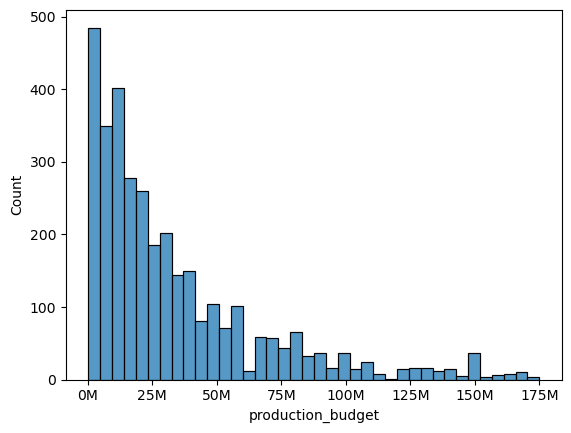

In [25]:
ax = sns.histplot(df["production_budget"])
ax.xaxis.set_major_formatter(fmt_M) # , log_scale=True

La distribución del presupuesto de producción es aprox log-normal.
- Cuales son las medianas?

/home/ismael/miniconda3/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 32'. Pick better value with 'binwidth'.


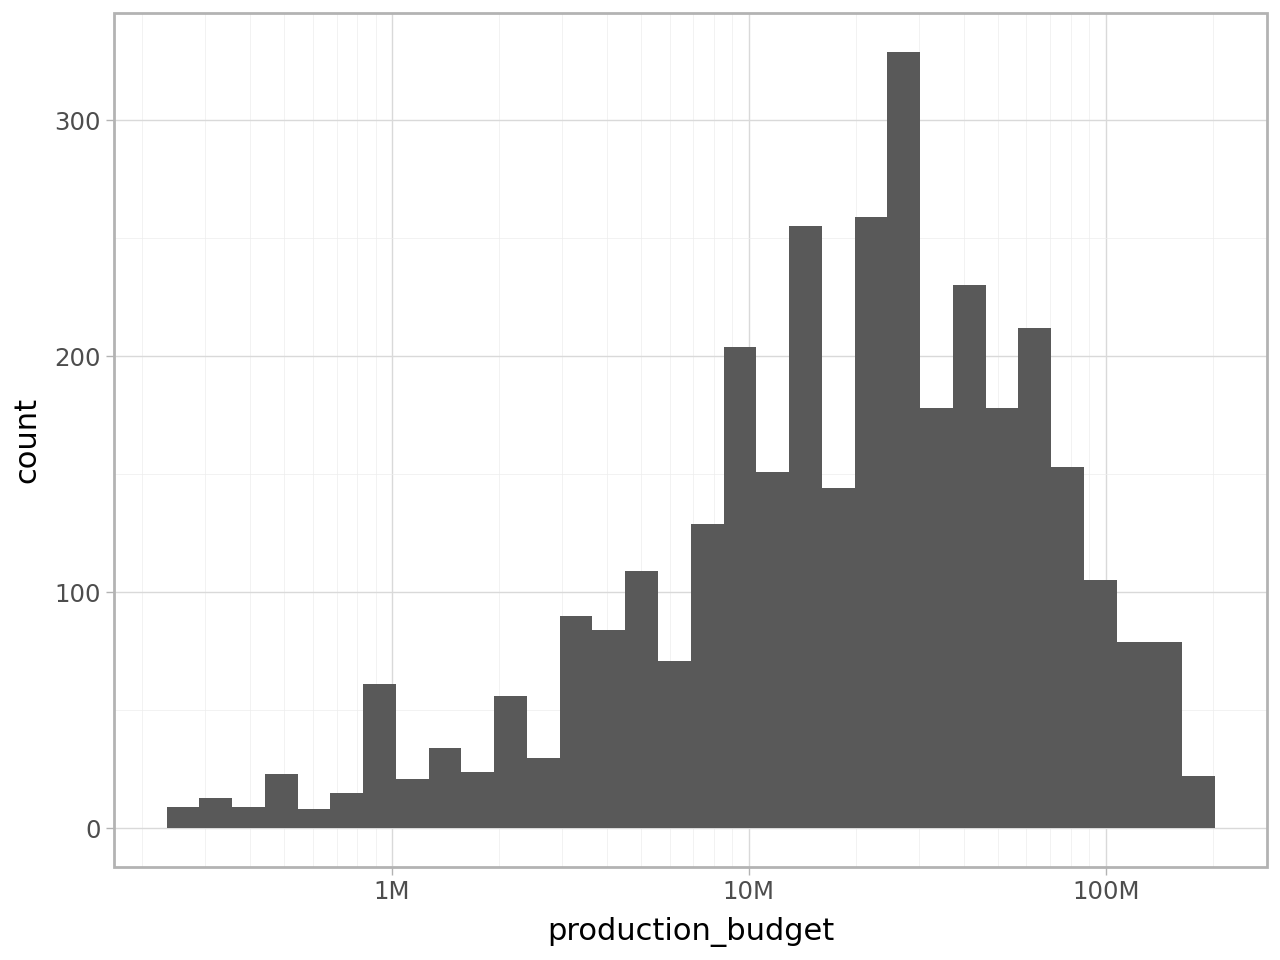

In [26]:
(
    pn.ggplot(df, pn.aes(x="production_budget"))
    + pn.geom_histogram()
    + pn.scale_x_log10(labels=pl_M)
)

Considerations:

- Almost every time you see money, you wanna put it in a log scale. Since they use to be log normal distributed.

Interpretation:

- Production budget kind of log normal distributed.
- It's probably not very lognormal because it has a factor influencing this: ditributer maybe

Questions:

- How to interpret/communicate a log scale histogram or any other plot in that scale?


In [27]:
df.describe(include=["O"])

,movie,distributor,mpaa_rating,genre,distributor_lumped
count,3364,3322,3232,3364,3364
unique,3364,188,4,5,6
top,Evan Almighty,Warner Bros.,R,Drama,Other
freq,1,373,1497,1223,1798


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3364 entries, 0 to 3363
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   release_date        3364 non-null   datetime64[ns]
 1   movie               3364 non-null   object        
 2   production_budget   3364 non-null   float64       
 3   domestic_gross      3364 non-null   float64       
 4   worldwide_gross     3364 non-null   float64       
 5   distributor         3322 non-null   object        
 6   mpaa_rating         3232 non-null   object        
 7   genre               3364 non-null   object        
 8   distributor_lumped  3364 non-null   object        
 9   decade              3364 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 262.9+ KB


### How many movies per distributor


In [29]:
(
    df[df["distributor_lumped"] != "Other"]
    .groupby("distributor_lumped")["movie"]
    .nunique()
    .sort_values()
    # .plot.barh()
)

distributor_lumped
Paramount Pictures    265
20th Century Fox      282
Universal             307
Sony Pictures         339
Warner Bros.          373
Name: movie, dtype: int64

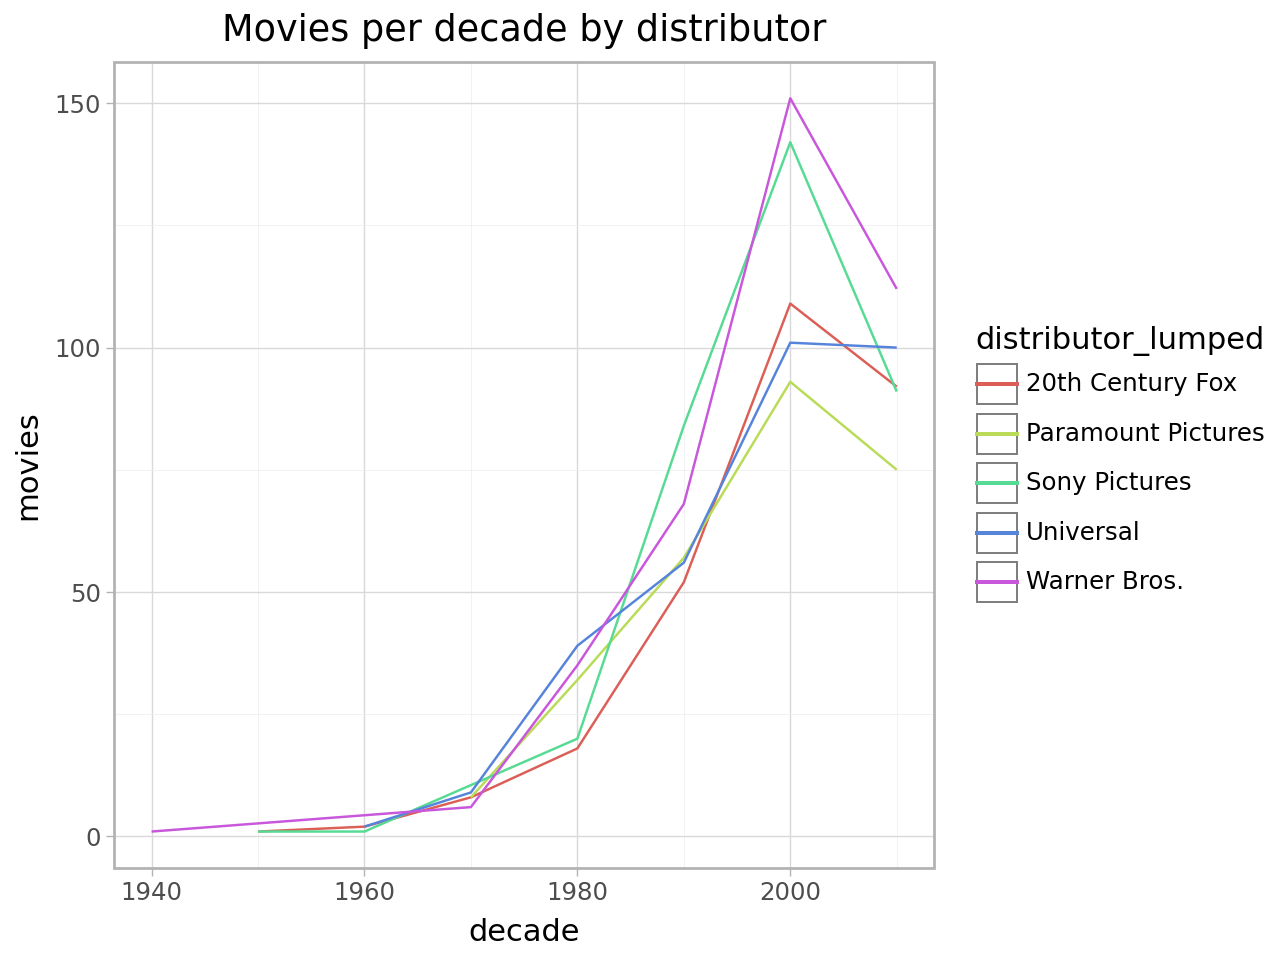

In [30]:
pdf = (
    df[df["distributor_lumped"] != "Other"]
    .groupby(["decade", "distributor_lumped"])["movie"]
    .nunique()
    .rename('movies')
    .reset_index()
    .sort_values("decade")
)

(
    pn.ggplot(pdf, pn.aes(x="decade", y="movies", color="distributor_lumped"))
    + pn.geom_line()
    + pn.ggtitle('Movies per decade by distributor')
)

La mayoria de peliculas del dataset tienen peliculas de entre las ultimas decadas (1990 en adelante).
- Esto es porque no se hacian tantas peliculas antes? o es una limitación del dataset?

En vez de ver el total, veamos las proporciones:

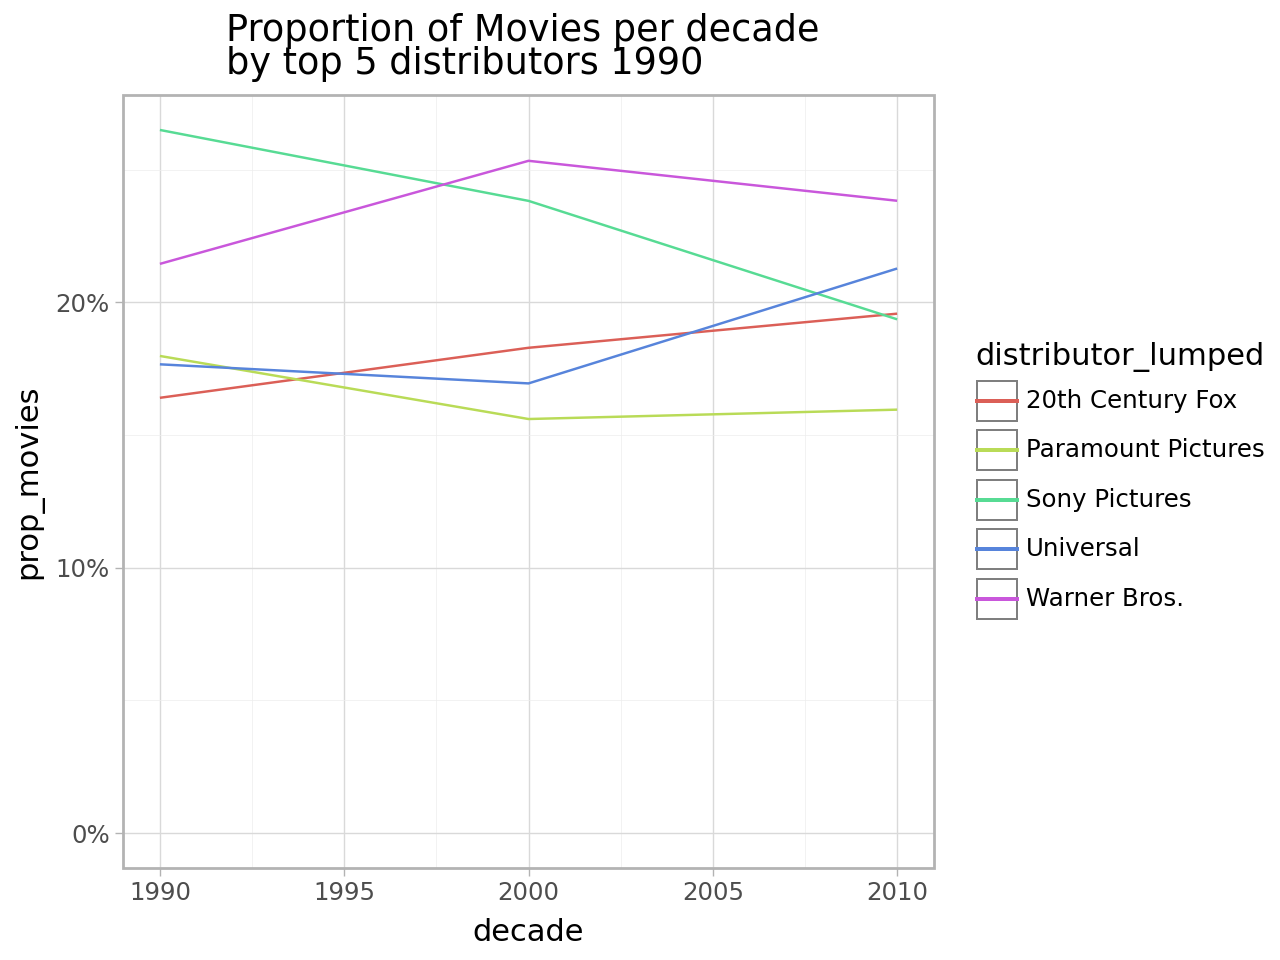

In [31]:
pdf["prop_movies"] = pdf.groupby(
    ["decade"],
    as_index=False,
)[
    "movies"
].transform(lambda x: x / x.sum())

(
    pn.ggplot(
        pdf[pdf["decade"] >= 1990],
        pn.aes(x="decade", y="prop_movies", color="distributor_lumped"),
    )
    + pn.geom_line()
    + pn.ggtitle("Proportion of Movies per decade \nby top 5 distributors 1990")
    + pn.scale_y_continuous(labels = pl_pct)
    + pn.expand_limits(y = 0)
)

Warner se ha mantenido en el top de distribuidores que más peliculas producen (dentro del top 5).

- Cuales son esas peliculas que producen?

Text(0.5, 1.0, 'Top 10 movies by worldwide gross')

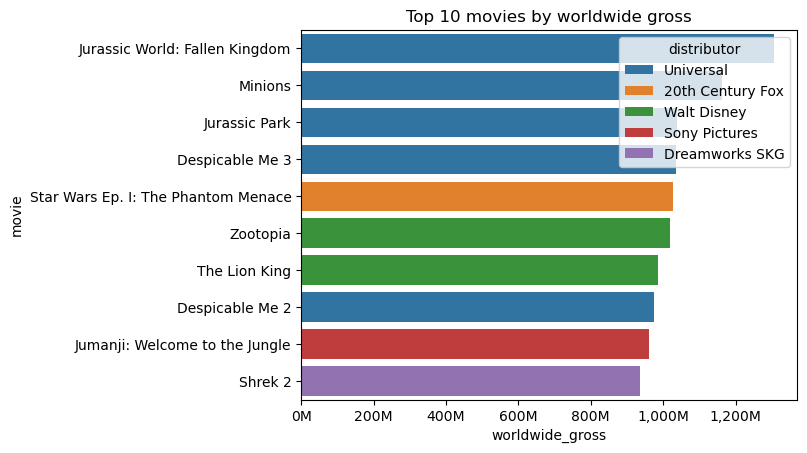

In [32]:
pdf = df.sort_values("worldwide_gross", ascending=False).head(10)

ax = sns.barplot(data=pdf, x="worldwide_gross", y="movie", hue="distributor")
ax.xaxis.set_major_formatter(fmt_M)
ax.set_title("Top 10 movies by worldwide gross")

Text(0.5, 1.0, 'Top 10 movies by domestic gross')

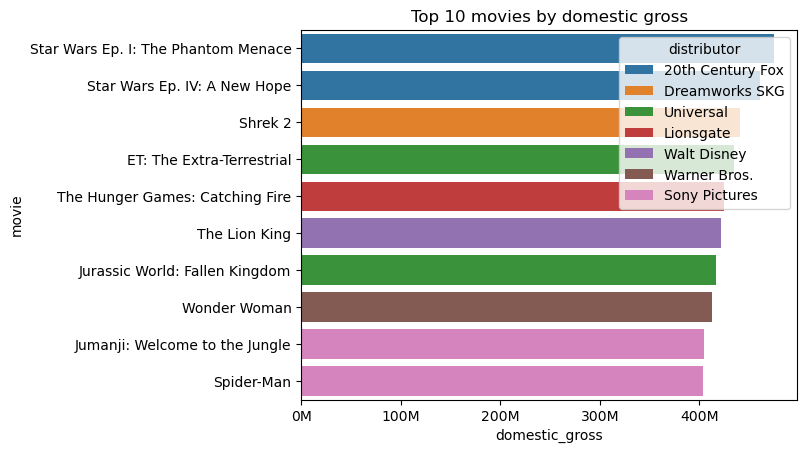

In [33]:
pdf = df.sort_values("domestic_gross", ascending=False).head(10)

ax = sns.barplot(data=pdf, x="domestic_gross", y="movie", hue="distributor")
ax.xaxis.set_major_formatter(fmt_M)
ax.set_title("Top 10 movies by domestic gross")

Text(0.5, 1.0, 'Top 10 movies by worldwide gross')

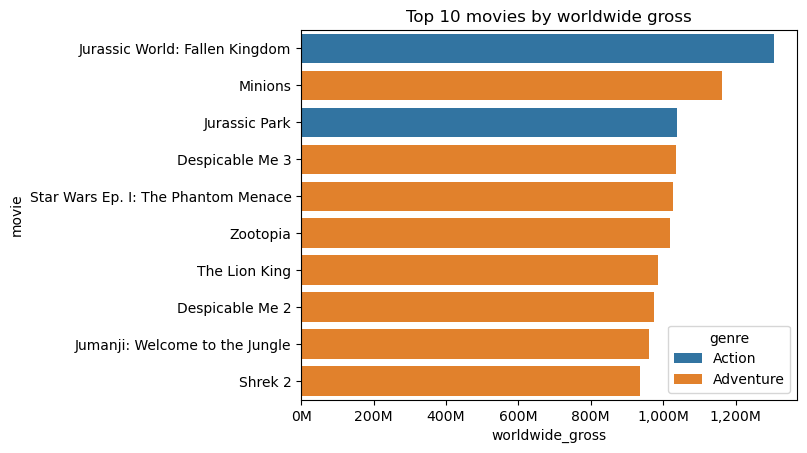

In [34]:
pdf = df.sort_values("worldwide_gross", ascending=False).head(10)

ax = sns.barplot(data=pdf, x="worldwide_gross", y="movie", hue="genre")
ax.xaxis.set_major_formatter(fmt_M)
ax.set_title("Top 10 movies by worldwide gross")

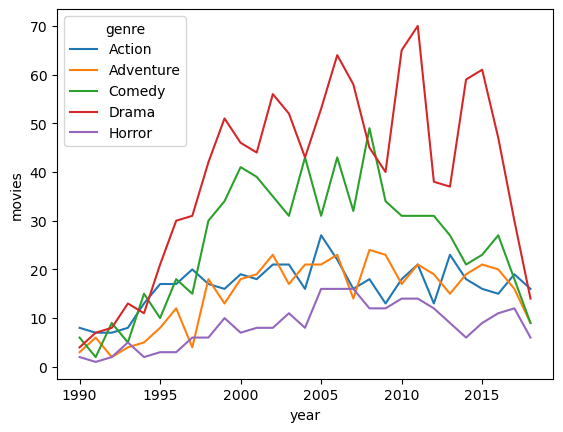

In [35]:
pdf = (
    df.assign(year=df["release_date"].dt.year)
    .groupby(['year', "genre"])
    .size()
    .rename("movies")
    .reset_index()
    .query('year >= 1990')
)

ax = sns.lineplot(
    data=pdf,
    x="year",
    y="movies",
    hue="genre",
)

# ax.xaxis.set_major_locator(ticker.FixedLocator(range(1990, 2020, 10)))
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))

### Genre distribution

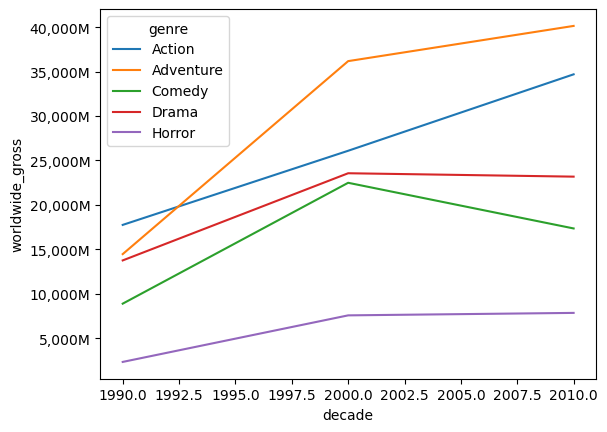

In [37]:
pdf = (
    df.assign(year=df["release_date"].dt.year)
    .groupby(['decade', "genre"])
    ['worldwide_gross'].sum()
    .reset_index()
    .query('decade >= 1990')
)

ax = sns.lineplot(
    data=pdf,
    x="decade",
    y="worldwide_gross",
    hue="genre",
)

ax.yaxis.set_major_formatter(fmt_M)

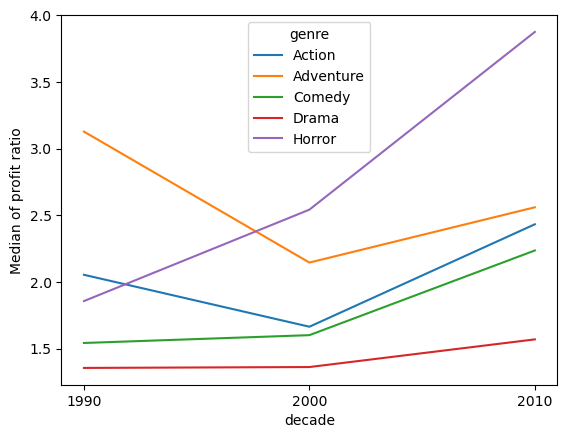

In [43]:
pdf = (
    df.assign(profit_ratio=df["worldwide_gross"] / df["production_budget"])
    .groupby(['decade', "genre"])
    ['profit_ratio'].median()
    .reset_index()
    .query('decade >= 1990')
)

ax = sns.lineplot(
    data=pdf,
    x="decade",
    y="profit_ratio",
    hue="genre",
)

ax.set_ylabel('Median of profit ratio')
ax.xaxis.set_major_locator(ticker.FixedLocator(range(1990, 2020, 10)))


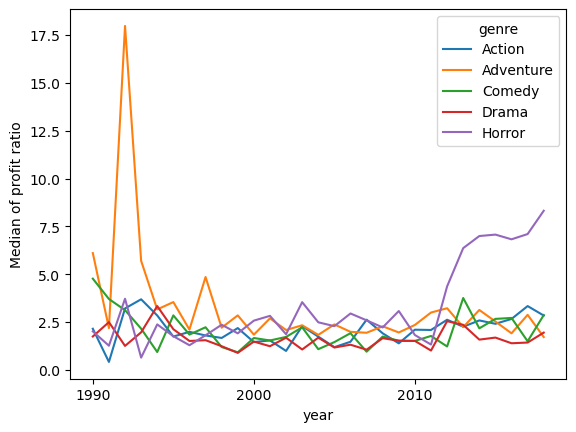

In [50]:
pdf = (
    df.assign(
        year=df["release_date"].dt.year
    )
    .groupby(['year', "genre"])
    ['profit_ratio'].median()
    .reset_index()
    .query('year >= 1990')
)

ax = sns.lineplot(
    data=pdf,
    x="year",
    y="profit_ratio",
    hue="genre",
)

ax.set_ylabel('Median of profit ratio')
ax.xaxis.set_major_locator(ticker.FixedLocator(range(1990, 2020, 10)))
